# Clustering Crypto

In [71]:
# Initial imports
import requests
import pandas as pd
import matplotlib.pyplot as plt
import hvplot.pandas
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

### Fetching Cryptocurrency Data

In [72]:
# Use the following endpoint to fetch json data
url = "https://min-api.cryptocompare.com/data/all/coinlist"

In [73]:
# Create a DataFrame 
# HINT: You will need to use the 'Data' key from the json response, then transpose the DataFrame.

In [74]:
# Alternatively, use the provided csv file:
from pathlib import Path
file_path = Path("crypto_data.csv")

# Create a DataFrame
crypto_df = pd.read_csv(file_path)

### Data Preprocessing

In [75]:
# Keep only necessary columns:
cols_to_keep = {'CoinName','Algorithm','IsTrading','ProofType','TotalCoinsMined','TotalCoinSupply'}
for col in crypto_df.columns:
    if col not in cols_to_keep:
        crypto_df = crypto_df.drop(columns=col)



In [76]:
# Keep only cryptocurrencies that are trading
mask = crypto_df['IsTrading'] == True
crypto_df = crypto_df[mask]
crypto_df = crypto_df.drop(columns='IsTrading')

In [77]:
# Keep only cryptocurrencies with a working algorithm


In [78]:
# Remove rows with at least 1 null value
crypto_df.dropna(inplace=True)

In [79]:
# Remove rows with cryptocurrencies having no coins mined
crypto_df = crypto_df[crypto_df['TotalCoinsMined']>0]

In [80]:
# Drop rows where there are 'N/A' text values
mask = crypto_df[crypto_df.columns]=='N/A'
crypto_df[mask==True].count()

CoinName           0
Algorithm          0
ProofType          0
TotalCoinsMined    0
TotalCoinSupply    0
dtype: int64

In [81]:
# Store the 'CoinName'column in its own DataFrame prior to dropping it from crypto_df
crypto_df_index = pd.Index(crypto_df['CoinName'])
crypto_df_index

Index(['42 Coin', '404Coin', 'EliteCoin', 'Bitcoin', 'Ethereum', 'Litecoin',
       'Dash', 'Monero', 'Ethereum Classic', 'ZCash',
       ...
       'TigerCash', 'Waves', 'Particl', 'BitTorrent', 'Nxt', 'ZEPHYR',
       'Gapcoin', 'Beldex', 'Horizen', 'BitcoinPlus'],
      dtype='object', name='CoinName', length=532)

In [82]:
# Drop the 'CoinName' column since it's not going to be used on the clustering algorithm
crypto_df = crypto_df.drop(columns='CoinName')

In [83]:
# Create dummy variables for text features
X = pd.get_dummies(crypto_df, columns=['Algorithm', 'ProofType'])

In [112]:
# Standardize data
# To test the scaling processes, we're going to need to find the best scale among min-max and the standard scaler. 
def choose_scale(df, st_or_mm = 'st'):
    """scale a dataframe. defaults to standard"""
    if st_or_mm == 'st':
        st_scaler = StandardScaler().fit(df)
        X_st_scaled = st_scaler.transform(df)
        return X_st_scaled
    else:
        mm_scaler = MinMaxScaler().fit(df)
        X_mm_scaled = mm_scaler.transform(df)
        return X_mm_scaled
      

### Reducing Dimensions Using PCA

In [117]:
# Use PCA to reduce dimensions to 3 principal components
X_scaled = choose_scale(X)
pca = PCA(n_components=3)


In [126]:
def get_pca_cols(gimme_np_array):
    ln = gimme_np_array.shape[1]
    cols = []
    for i in range(ln):
        cols.append(f'PC {i+1}')
    return cols


['PC 1', 'PC 2', 'PC 3']

In [127]:
# Create a DataFrame with the principal components data
pca_df = pd.DataFrame(pca.fit_transform(X_scaled), columns=get_pca_cols(pca.fit_transform(X_scaled)),index= crypto_df_index)
pca_df

,PC 1,PC 2,PC 3
CoinName,,,
42 Coin,-0.324291,0.907046,-0.535127
404Coin,-0.307653,0.907361,-0.535500
EliteCoin,2.314204,1.559981,-0.672246
Bitcoin,-0.148111,-1.241395,0.168035
Ethereum,-0.162762,-1.948124,0.317690
...,...,...,...
ZEPHYR,2.493811,0.619100,-0.014662
Gapcoin,-0.322340,0.906966,-0.535151
Beldex,0.315733,-2.167719,0.406801


### Clustering Crytocurrencies Using K-Means

#### Find the Best Value for `k` Using the Elbow Curve

In [132]:

# Calculate the inertia for the range of k values
def get_elbow(df, max_k=11):
    inertia = []
    k = list(range(1, max_k))
    for i in k:
        k_model = KMeans(n_clusters=i)
        k_model.fit(df)
        inertia.append(k_model.inertia_)
    return pd.DataFrame({'k': k, 'inertia': inertia})
# Create the Elbow Curve using hvPlot
get_elbow(pca_df).hvplot.line(x="k",y="inertia",title="Elbow Curve")

c:\Users\Laramie\anaconda3\envs\dev\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  "KMeans is known to have a memory leak on Windows "


:Curve   [k]   (inertia)

Running K-Means with `k=6`

In [134]:
# Initialize the K-Means model
kmeans_model = KMeans(n_clusters=6, random_state=1)

# Fit the model
kmeans_model.fit(pca_df)

# Predict clusters
pca_df['Class'] = kmeans_model.predict(pca_df)

# Create a new DataFrame including predicted clusters and cryptocurrencies features
pca_df.hvplot.scatter(x='PC 1', y='PC 2', by='Class')

:NdOverlay   [Class]
   :Scatter   [PC 1]   (PC 2)

c:\Users\Laramie\anaconda3\envs\dev\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  """


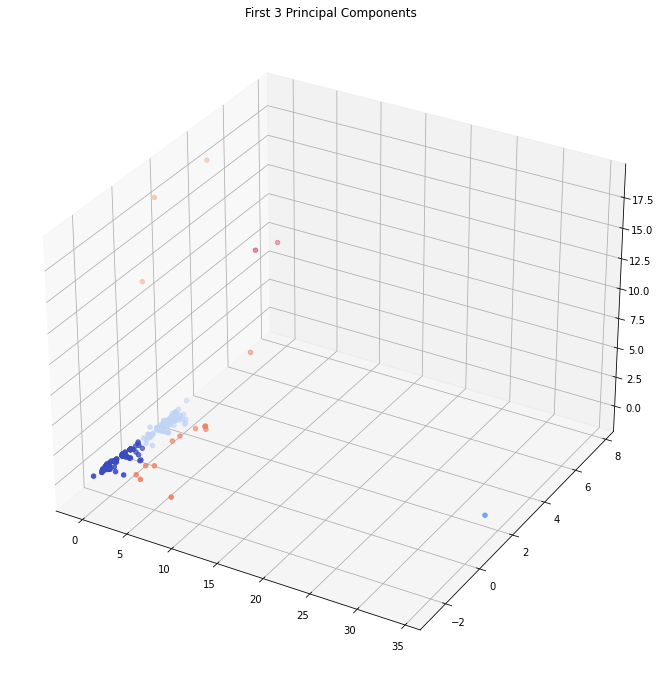

In [153]:
## I did this purely out of curiosity -- just wanted to see what it looked like :)

from mpl_toolkits.mplot3d import Axes3D
def plot_first3(df, class_col):
    """a method to plot the first three components of a pca dataframe"""
    fig = plt.figure(figsize=(12,9))
    ax = Axes3D(fig)
    y = df.iloc[:,1]
    x = df.iloc[:,0]
    z = df.iloc[:,2]
    c = df[class_col]
    ax.scatter(x,y,z, c=c, cmap='coolwarm')
    plt.title('First 3 Principal Components')
plot_first3(pca_df,'Class') 

### Visualizing Results

#### Scatter Plot with Tradable Cryptocurrencies

In [89]:
# Scale data to create the scatter plot


In [90]:
# Plot the scatter with x="TotalCoinsMined" and y="TotalCoinSupply"


#### Table of Tradable Cryptocurrencies

In [91]:
# Table with tradable cryptos


In [92]:
# Print the total number of tradable cryptocurrencies
